# Assignment 1

In [17]:
#Setup
!pip -q install pandas numpy matplotlib
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from textwrap import fill

# Create folders
ROOT = Path('.')
(ROOT / 'data' / 'raw').mkdir(parents=True, exist_ok=True)
(ROOT / 'data' / 'external').mkdir(parents=True, exist_ok=True)
(ROOT / 'outputs' / 'q1').mkdir(parents=True, exist_ok=True)
(ROOT / 'outputs' / 'q2').mkdir(parents=True, exist_ok=True)
(ROOT / 'reports').mkdir(parents=True, exist_ok=True)
print('Folders ready.')


Folders ready.


## Q1 — Frailty mini‑analysis



In [18]:
# 1) sample CSV so the cell always runs
frailty_csv = '''Height_in,Weight_lb,Age_yr,Grip_kg,Frailty
65.8,112,30,30,N
71.5,136,19,31,N
69.4,153,45,29,N
68.2,142,22,28,Y
67.8,144,29,24,Y
68.7,123,50,26,N
69.8,141,51,22,Y
70.1,136,23,20,Y
67.9,112,17,19,N
66.8,120,39,31,N
'''
print('Wrote data/raw/frailty_females.csv')

# 2) Load + basic feature engineering
df = pd.read_csv(ROOT / 'data' / 'raw' / 'frailty_females.csv')
df['Height_m']  = df['Height_in'] * 0.0254
df['Weight_kg'] = df['Weight_lb'] * 0.45359237
df['BMI'] = (df['Weight_kg'] / (df['Height_m']**2)).round(2)

def to_age_group(age):
    if age < 30: return '<30'
    if 30 <= age <= 45: return '30–45'
    if 46 <= age <= 60: return '46–60'
    return '>60'
df['AgeGroup'] = df['Age_yr'].apply(to_age_group)
df['Frailty_binary'] = (df['Frailty'].str.upper().map({'Y':1, 'N':0})).astype('int8')

# 3) Save outputs
clean_path = ROOT / 'outputs' / 'q1' / 'frailty_processed.csv'
df.to_csv(clean_path, index=False)
summary = df.select_dtypes(include=['number']).agg(['mean','median','std']).T
summary_path = ROOT / 'outputs' / 'q1' / 'summary_numeric.csv'
summary.to_csv(summary_path)
corr = df['Grip_kg'].corr(df['Frailty_binary'])

lines = []
lines.append('# Q1 — Frailty Mini-Report (Beginner)\n')
lines.append('**What I did:** Cleaned units, created BMI, made age groups, and turned frailty into 0/1.\n')
lines.append('**Where to find outputs:**\n')
lines.append(f'- Clean table: {clean_path}')
lines.append(f'- Summary table: {summary_path}\n')
lines.append('**A quick finding:**')
lines.append(f'- Correlation between *Grip_kg* and *Frailty (0/1)* is **{corr:.3f}**.\\n')


Wrote data/raw/frailty_females.csv


## Q2 — Student performance

In [19]:
from google.colab import files
import io
import pandas as pd

target = ROOT / 'data' / 'external' / 'StudentsPerformance.csv'
if not target.exists():
    print('Optional: Upload StudentsPerformance.csv to use the full dataset (cancel to use the sample).')
    uploaded = files.upload()  # user may cancel
    for name, content in uploaded.items():
        if name.lower().endswith('.csv'):
            target.write_bytes(content)
            print('Saved', target)
            break

sample_path = ROOT / 'data' / 'external' / 'StudentsPerformance_sample.csv'
if not sample_path.exists():
    sample_csv = '''gender,lunch,test preparation course,math score,reading score,writing score
female,standard,completed,72,84,81
male,free/reduced,none,70,65,60
female,standard,completed,88,95,92
male,free/reduced,none,60,58,55
female,standard,none,80,85,82
male,standard,completed,78,74,76\n'''
    print('Wrote sample:', sample_path)

DATA = target if target.exists() else sample_path
print('Using:', DATA)


Optional: Upload StudentsPerformance.csv to use the full dataset (cancel to use the sample).


Saving StudentsPerformance.csv to StudentsPerformance.csv
Saved data/external/StudentsPerformance.csv
Using: data/external/StudentsPerformance.csv


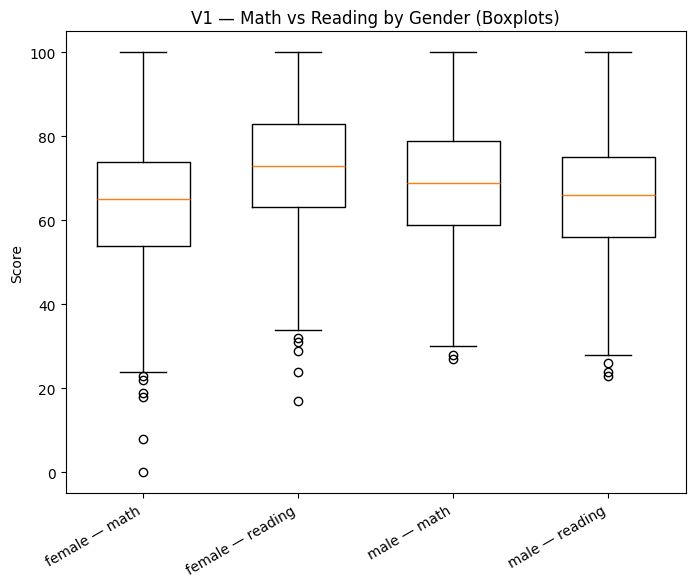

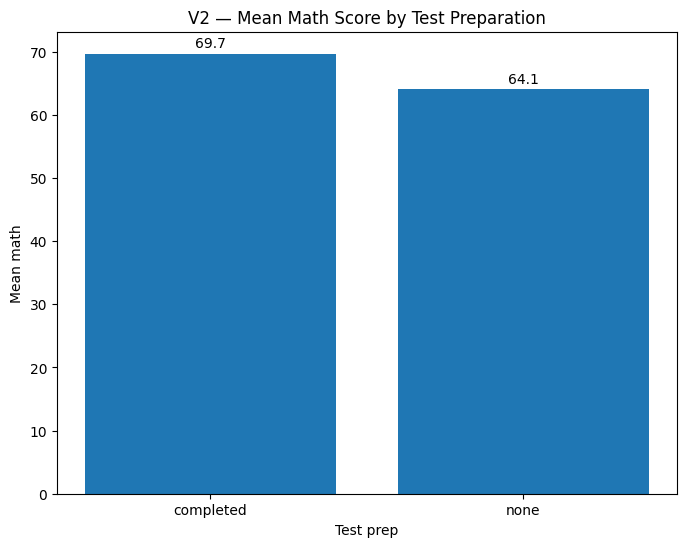

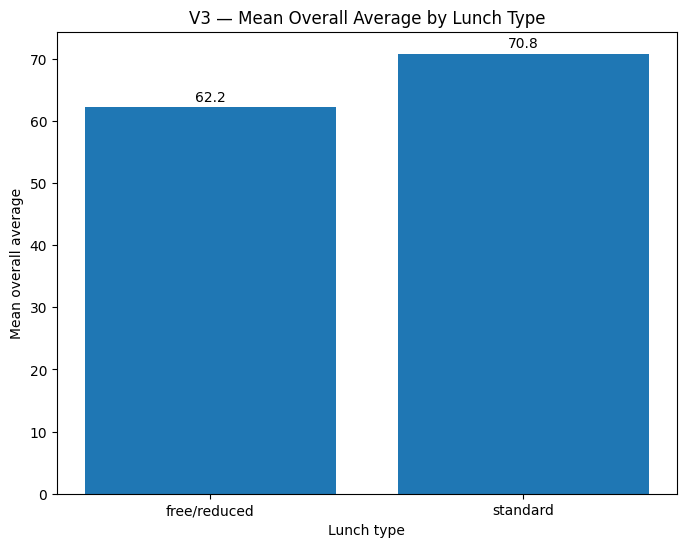

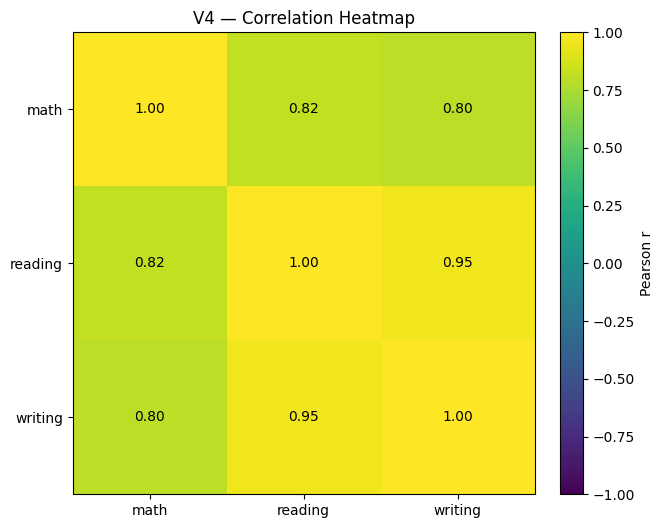

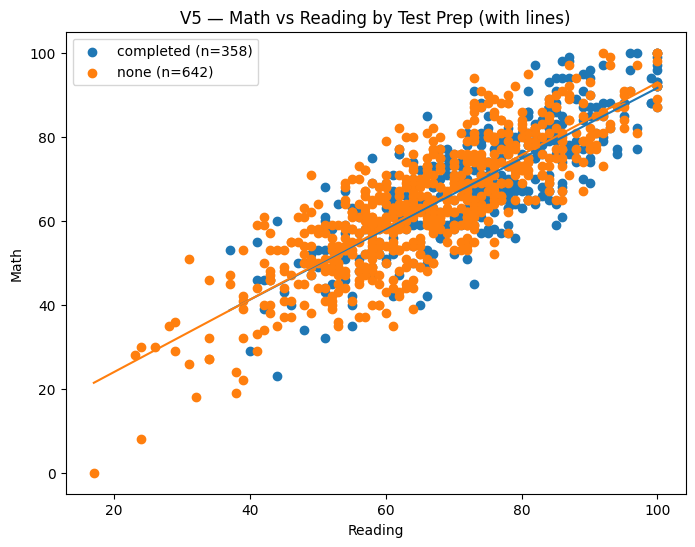

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100

df = pd.read_csv(DATA)
colmap = {
    'math score':'math',
    'reading score':'reading',
    'writing score':'writing',
    'test preparation course':'test_prep'
}
for old, new in colmap.items():
    if old in df.columns:
        df.rename(columns={old:new}, inplace=True)

needed = ['gender','lunch','test_prep','math','reading','writing']
df = df.dropna(subset=needed).copy()
df['overall_avg'] = df[['math','reading','writing']].mean(axis=1)

# Helper
# V1: Boxplots (math vs reading by gender)
fig1, ax1 = plt.subplots()
labels, data = [], []
for g in df['gender'].unique():
    labels += [f'{g} — math', f'{g} — reading']
    data   += [df.loc[df['gender']==g, 'math'].values,
               df.loc[df['gender']==g, 'reading'].values]
ax1.boxplot(data, positions=range(1, len(data)+1), widths=0.6)
ax1.set_xticks(range(1, len(data)+1), labels, rotation=30, ha='right')
ax1.set_ylabel('Score')
ax1.set_title('V1 — Math vs Reading by Gender (Boxplots)')
plt.show()

# V2: Test prep impact on math
fig2, ax2 = plt.subplots()
means = df.groupby('test_prep')['math'].mean().sort_index()
ax2.bar(means.index, means.values)
ax2.set_title('V2 — Mean Math Score by Test Preparation')
ax2.set_xlabel('Test prep')
ax2.set_ylabel('Mean math')
for i, v in enumerate(means.values):
    ax2.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')
plt.show()

# V3: Lunch type vs overall average
fig3, ax3 = plt.subplots()
m = df.groupby('lunch')['overall_avg'].mean().sort_index()
ax3.bar(m.index, m.values)
ax3.set_title('V3 — Mean Overall Average by Lunch Type')
ax3.set_xlabel('Lunch type')
ax3.set_ylabel('Mean overall average')
for i, v in enumerate(m.values):
    ax3.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')
plt.show()

# V4: Correlation heatmap
corr = df[['math','reading','writing']].corr()
fig4, ax4 = plt.subplots()
im = ax4.imshow(corr.values, vmin=-1, vmax=1)
ax4.set_xticks([0,1,2], ['math','reading','writing'])
ax4.set_yticks([0,1,2], ['math','reading','writing'])
for i in range(3):
    for j in range(3):
        ax4.text(j, i, f'{corr.values[i,j]:.2f}', ha='center', va='center')
fig4.colorbar(im, ax=ax4, fraction=0.046, pad=0.04, label='Pearson r')
ax4.set_title('V4 — Correlation Heatmap')
plt.show()

# V5: Math vs Reading with group lines (by test_prep)
fig5, ax5 = plt.subplots()
for g in sorted(df['test_prep'].unique()):
    sub = df[df['test_prep']==g]
    ax5.scatter(sub['reading'], sub['math'], label=f'{g} (n={len(sub)})')
    a, b = np.polyfit(sub['reading'], sub['math'], 1)
    xs = np.array([sub['reading'].min(), sub['reading'].max()])
    ys = a*xs + b
    ax5.plot(xs, ys)
ax5.set_xlabel('Reading')
ax5.set_ylabel('Math')
ax5.set_title('V5 — Math vs Reading by Test Prep (with lines)')
ax5.legend()
plt.show()